# CNN on Cifar10

In [2]:
import sys, os, json, time
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()


In [3]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [4]:
# load the datasets
train_dataset = datasets.CIFAR10(
    root=".",
    download=True,
    train=True,
    transform=transforms.ToTensor()  # its not called until dataloader is called
)

test_dataset = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# explore the datasets a little
train_dataset_shape = train_dataset.data.shape
print(f"[INFO] train_dataset_shape: {train_dataset_shape}......")

test_dataset_shape = test_dataset.data.shape
print(f"[INFO] test_dataset_shape: {test_dataset_shape}......")

[INFO] train_dataset_shape: (50000, 32, 32, 3)......
[INFO] test_dataset_shape: (10000, 32, 32, 3)......


So it looks like the images are 3 channel color images. Notice that in the dataset, the channels are last just like it is in opencv/keras. However after loading in dataloader, the transform functions will make it channel first.

In [6]:
# lets look at the targets
type(train_dataset.targets)


list

The targets are stored as list. will need to be converted to Tensors. It should be done by the dataloader.

In [7]:
# evaluate the unique no of classes
num_classes = len(set(train_dataset.targets))
print(f"[INFO] there are total {num_classes} unique classes......")

[INFO] there are total 10 unique classes......


In [8]:
# now create the dataloaders
batch_size = 128
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [9]:
# define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # define conv layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size=3,
                               stride=2)
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               stride=2)
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               stride=2)
        # output of last conv is 3 x 3 activation map
        # define linear layers
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # different - we are using Functional module
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 3 * 3)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)  # model outputs logits

        return x

In [10]:
# set device and instantiate model
model = CNN(num_classes=num_classes)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"[INFO] available device: {device}......")

# move model to device
model.to(device=device)

[INFO] available device: cuda:0......


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [11]:
# set the criterions and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [12]:
# function to train the model
def batch_gd(model: nn.Module,
             criterion: nn.CrossEntropyLoss,
             optimizer: optim.Adam,
             train_loader: DataLoader,
             test_loader: DataLoader,
             epochs: int):
    # initalise the loss arrays
    epoch_train_losses = np.zeros(epochs)
    epoch_test_losses = np.zeros(epochs)

    # start the training loop
    for epoch in range(epochs):
        # set mode to model train to turn on dropout, batchnorm
        model.train()
        start_epoch = time.time()
        batch_train_losses = []
        batch_test_losses = []

        for inputs, targets in train_loader:
            # move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the optimizer
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # backward step and optimize
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        # now start the eval loop
        for inputs, targets in test_loader:
            model.eval()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_test_losses.append(loss.item())

        # after everything is done
        end_epoch = time.time()
        epoch_train_loss = np.mean(batch_train_losses)
        epoch_test_loss = np.mean(batch_test_losses)
        epoch_train_losses[epoch] = epoch_train_loss
        epoch_test_losses[epoch] = epoch_test_loss

        print(f"[INFO] epoch: {epoch + 1} with train_loss: {epoch_train_loss: 0.3f} and test_loss: {epoch_test_loss: 0.3f} took {end_epoch - start_epoch: 0.3f} seconds......")

    return epoch_train_losses, epoch_test_losses

In [13]:
# train the model
train_losses, test_losses = batch_gd(model=model,
         criterion=criterion,
         optimizer=optimizer,
         train_loader=train_loader,
         test_loader=test_loader,
         epochs=15)

[INFO] epoch: 1 with train_loss:  1.715 and test_loss:  1.469 took  99.911 seconds......
[INFO] epoch: 2 with train_loss:  1.415 and test_loss:  1.353 took  24.753 seconds......
[INFO] epoch: 3 with train_loss:  1.288 and test_loss:  1.260 took  25.429 seconds......
[INFO] epoch: 4 with train_loss:  1.203 and test_loss:  1.198 took  25.010 seconds......
[INFO] epoch: 5 with train_loss:  1.130 and test_loss:  1.147 took  25.669 seconds......
[INFO] epoch: 6 with train_loss:  1.073 and test_loss:  1.117 took  39.945 seconds......
[INFO] epoch: 7 with train_loss:  1.033 and test_loss:  1.086 took  34.257 seconds......
[INFO] epoch: 8 with train_loss:  0.986 and test_loss:  1.063 took  33.084 seconds......
[INFO] epoch: 9 with train_loss:  0.951 and test_loss:  1.057 took  33.325 seconds......
[INFO] epoch: 10 with train_loss:  0.911 and test_loss:  1.047 took  33.635 seconds......
[INFO] epoch: 11 with train_loss:  0.878 and test_loss:  1.017 took  30.469 seconds......
[INFO] epoch: 12 wi

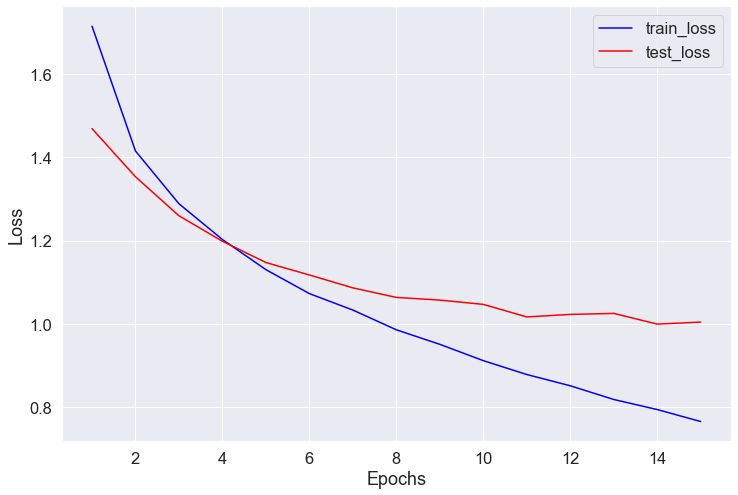

In [14]:
sns.set(font_scale=1.5)
f, ax = plt.subplots(1, 1, figsize=(12, 8))  # type: Figure, Axes
x = np.arange(15) + 1
sns.lineplot(x=x, y=train_losses, ax=ax, color="blue", label="train_loss")
sns.lineplot(x=x, y=test_losses, ax=ax, color="red", label="test_loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");


In [15]:
# calculate model accuracies
train_corrects = 0
test_corrects = 0
train_total = 0
test_total = 0

model.eval()
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, indices = torch.max(outputs, dim=1)
        corrects = (targets == indices).sum().item()
        train_corrects += corrects
        total = targets.shape[0]
        train_total += total

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, indices = torch.max(outputs, dim=1)
        corrects = (targets == indices).sum().item()
        test_corrects += corrects
        total = targets.shape[0]
        test_total += total

print(f"[INFO] train_acc: {(train_corrects/train_total): 0.3f} and test_acc: {(test_corrects/test_total): 0.3f}......")        

[INFO] train_acc:  0.740 and test_acc:  0.645......


In [16]:
# plot the confusion matrix
x_test = test_dataset.data
all_true_targets = np.array([])
all_predictions = np.array([])

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, indices = torch.max(outputs, dim=1)
        all_true_targets = np.concatenate((all_true_targets, targets.cpu().numpy()))
        all_predictions = np.concatenate((all_predictions, indices.cpu().numpy()))

In [17]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix


def print_confusion_matrix(confusion_matrix, class_names, figsize=(10, 7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

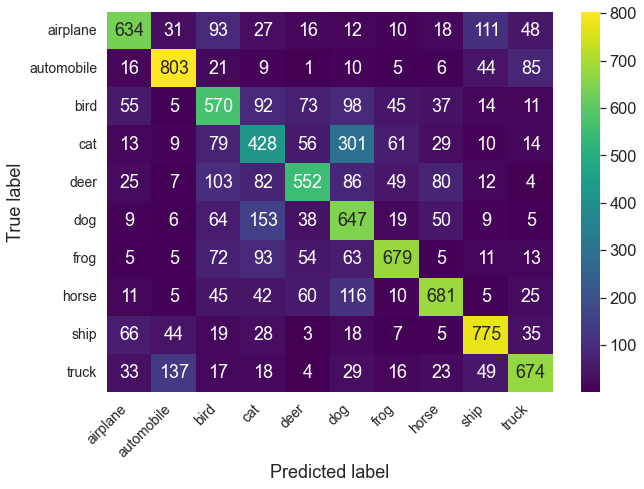

In [18]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
id_to_names = {i:name for i, name in enumerate(labels)}
cm = confusion_matrix(all_true_targets, all_predictions)
print_confusion_matrix(cm, class_names=labels)

[INFO] true_label: dog and predicted_label: cat......


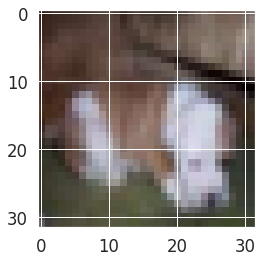

In [47]:
# indices where preds dont match targets
no_match_indices= np.where(all_true_targets != all_predictions)[0]

# look at misclassified images
random_id = np.random.choice(no_match_indices)

# choose a rnadom image from test set
x_random = x_test[random_id]

# plt the randomly chosen image
plt.imshow(x_random)

# get the true target label
true_label = id_to_names[all_true_targets[random_id]]
predicted_label = id_to_names[all_predictions[random_id]]
print(f"[INFO] true_label: {true_label} and predicted_label: {predicted_label}......")